# Using Gradient Descent to Decompose Matrix

Lets say u wanna decompose matrix A which is a MxN matrix into a MxZ matrix (B) * a ZxN matrix (C).

I propose the following stupid algorithm for such a decomposition:

1. create a nerual network which has two linear layers and is just input * B * C
2. get training data of X = rand() and Y = AX
3. train the BC nn on that training data using gradient descent
4. bing bang boom BC=A

In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random as rng
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

rng.seed(420)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Matrix to Decompose

We will test this methodology on a randomly generated 3x5 matrix A. It will be decomposed into the product of a 3x6 matrix and a 6x5 matrix.

In [3]:
M = 3
N = 5
Z = 6
A = torch.Tensor([[rng.randint(0, 20) for _ in range(N)] for _ in range(M)])
A.size(), A

(torch.Size([3, 5]),
 tensor([[ 0., 11.,  8., 12.,  3.],
         [ 3.,  0., 16., 10., 15.],
         [20.,  0., 19.,  4., 17.]]))

## Dataset Generation

Create train and test dataset with a random input and an output of A * the random input

In [4]:
class RNGDataset(Dataset):
    def __init__(self, A, length):
        self._len = length
        self._A = A

    def __getitem__(self, _index):
        _, N = self._A.size()
        X = torch.rand(N)
        Y = torch.matmul(A, X)
        return X, Y

    def __len__(self):
        return self._len

train_dataset = RNGDataset(A, int(1e4))
test_dataset = RNGDataset(A, int(1e2))

## Sanity Checks

* small dataloader to verify that the data feeds through our model
* assert that one of the weights is a MxZ matrix
* assert that one of the weights is a ZxN matrix

In [5]:
weight_dim_check_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, num_workers=0)

In [6]:
CLayer = nn.Linear(N, Z, bias=False)
BLayer = nn.Linear(Z, M, bias=False)
nn.init.kaiming_normal_(CLayer.weight)
nn.init.kaiming_normal_(BLayer.weight)
assert BLayer.weight.size() == torch.Size([M, Z])
assert CLayer.weight.size() == torch.Size([Z, N])

In [7]:
model = nn.Sequential(CLayer, BLayer).to(device)

model(next(iter(weight_dim_check_loader))[0].to(device)).size()

torch.Size([4, 3])

## Training

Now that we know all our matrix sizes are correct, we can start training the decomposition. We will use:

* sgd of lr=.1, momentum=0
* loss fn of MSELoss
* train batch size of 256

In [8]:
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False, num_workers=4)
train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True, num_workers=4)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=.01, momentum=0)

In [9]:
train_losses = []
test_losses = []
epochs = 50

for epoch in tqdm(range(epochs)):
    model.train()

    running_loss = []
    beg = time.time()
    for i, (data, target) in enumerate(weight_dim_check_loader):
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)
        y_pred = model(data)
        loss = criterion(y_pred, target)
        running_loss.append(loss.detach().item())
        if torch.isnan(loss):
            raise ValueError("NaN loss")

        loss.backward()
        optimizer.step()
        # print(f"Progress: {i}/{len(train_loader)}, {int(time.time() - beg)}s", end="\r", flush=True)
    train_losses.append(sum(running_loss) / len(running_loss))
    fmt_args = (epoch, train_losses[-1])
    # print("[TRAIN] epoch: %5d, loss: %.7f" % fmt_args, end="    ")

    with torch.no_grad():
        model.eval()

        running_loss = []
        for data, target in test_loader:
            optimizer.zero_grad()
            data, target = data.to(device), target.to(device)
            y_pred = model(data)
            loss = criterion(y_pred, target)
            running_loss.append(loss.detach().item())

        test_losses.append(sum(running_loss) / len(running_loss))
        fmt_args = (epoch, test_losses[-1], int(time.time() - beg))
        # print("[TEST] epoch: %5d, loss: %.7f %ds" % fmt_args)


  0%|          | 0/50 [00:00<?, ?it/s]

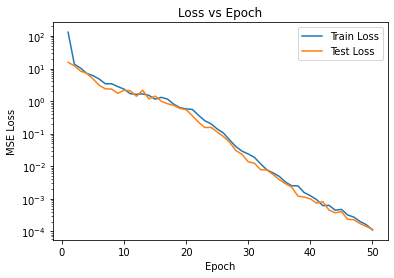

In [10]:
train_losses = np.array(train_losses)
test_losses = np.array(test_losses)
epochs = np.array([*range(1, len(train_losses) + 1)])
plt.plot(epochs, train_losses)
plt.plot(epochs, test_losses)
plt.legend(["Train Loss", "Test Loss"])
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Loss vs Epoch")
plt.show()

## Evaluation

We will now test how close our decomposition of B * C is to the original matrix A

In [11]:
with torch.no_grad():
    B = BLayer.weight.to("cpu")
    C = CLayer.weight.to("cpu")
    A_new = torch.matmul(B, C)
A, A_new, torch.round(A_new), all(torch.flatten(A == torch.round(A_new)))

(tensor([[ 0., 11.,  8., 12.,  3.],
         [ 3.,  0., 16., 10., 15.],
         [20.,  0., 19.,  4., 17.]]),
 tensor([[ 1.3105e-02,  1.0979e+01,  7.9919e+00,  1.2026e+01,  2.9942e+00],
         [ 2.9845e+00,  2.4551e-02,  1.6009e+01,  9.9692e+00,  1.5007e+01],
         [ 2.0007e+01, -1.0916e-02,  1.8996e+01,  4.0137e+00,  1.6997e+01]]),
 tensor([[ 0., 11.,  8., 12.,  3.],
         [ 3.,  0., 16., 10., 15.],
         [20., -0., 19.,  4., 17.]]),
 True)

In [12]:
B, C

(tensor([[ 1.3164,  1.0516, -0.4988,  0.7758,  1.9511,  2.6335],
         [ 1.3742,  0.0902, -1.1224,  2.8127,  2.8292, -1.0692],
         [ 1.4569,  3.1485, -2.7238, -0.2630,  2.2019, -2.5042]]),
 tensor([[ 0.8379,  0.6756,  1.3946,  1.4864,  0.9122],
         [ 2.3855,  1.4048,  1.1132,  0.8053,  1.2358],
         [-1.8062,  0.1746, -2.3772, -0.1622, -0.7896],
         [-1.5126, -0.1016,  1.2604,  1.7130,  1.5233],
         [ 0.6890,  0.8327,  2.4645,  1.6639,  2.2179],
         [-1.7734,  2.7166, -0.7544,  1.7340, -2.0540]]))

## Results

The decomposition of A = BC was fairly accurate. All the rounded values of BC equal the values of the original matrix A. Also, the unrounded values are fairly close to the values of A.